In [1]:
# !cp drive/MyDrive/python檔/aicup/run/dataset.py .
# !cp drive/MyDrive/python檔/aicup/run 

# loading

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import sys
sys.path.insert(0,"/content/drive/My Drive/python檔/aicup/run")

In [4]:
pip install transformers==3

     |████████████████████████████████| 757kB 10.6MB/s 
     |████████████████████████████████| 890kB 24.7MB/s 
     |████████████████████████████████| 1.1MB 36.2MB/s 
     |████████████████████████████████| 3.0MB 42.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=189babe9ff011bee1d6d23e60f6437adbbfe519e83fbb86c022e3465a3ce7e36
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [5]:
pip install pytorch-crf

In [6]:
pip install pytorch_warmup

In [7]:
# from dataset import bert_stc_dataset
# from model2 import model_crf
from train import train
# from txt_preprocess2 import preprocess2
import re

from transformers import BertModel, BertTokenizer, get_cosine_schedule_with_warmup
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from torchcrf import CRF
import pytorch_warmup as warmup
# from torch.autograd import Variable
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence


from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt

In [8]:
file_path = '/content/drive/My Drive/python檔/aicup/run/data/train_input.data'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('{} is being used'.format(device))

cuda is being used


# dataset

In [9]:
from torch.utils.data import Dataset
import torch

class bert_stc_dataset(Dataset):
    
    def __init__(self, stcs, labels, tokenizer, max_length):
        
        self.stcs = stcs
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.pad_labels = []

        # 已經在preprocess2 做完label 0 padding
        for i in range(len(labels)):
            temp_label = [0]*max_length
            temp_label[:len(labels[i])] = labels[i]
            self.pad_labels.append(temp_label)
            
        
    def __len__(self):
        return len(self.stcs)
    
    def __getitem__(self, idx):
        
        txt = str(self.stcs[idx])
        
        txt = ' '.join(list(txt))
        # print(txt)
        
        encoding = self.tokenizer.encode_plus(
            txt,
#             truncation= True,
            max_length= self.max_length,
            padding = 'max_length',
            add_special_tokens=False,
#             pad_to_multiple_of=True,
            return_attention_mask= True,
            return_token_type_ids= False,
            return_tensors='pt')
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels' : torch.tensor(self.pad_labels[idx], dtype= torch.long)
        }

# preprocess

In [10]:
class preprocess2():
  def __init__(self, data):
    self.data = data
    self.article_id_list = list()
    self.data_list= list()
    data_list_tmp = list()
    idx = 0

    for row in data:
      data_tuple = tuple()
      if row == '\n':
        self.article_id_list.append(idx)
        idx+=1
        self.data_list.append(data_list_tmp)
        data_list_tmp = []

      else:
        row = row.strip('\n').split(' ')

        if (row[0] == '，') & (len(data_list_tmp) >= 96):
          self.article_id_list.append(idx)
          self.data_list.append(data_list_tmp)
          data_list_tmp= []

        elif row[0] in ['。', '？','！','～','：']:
          self.article_id_list.append(idx)
          self.data_list.append(data_list_tmp)
          data_list_tmp= []
        
        elif row[0] in ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']:
          print(row[0])
          data_tuple = (row[0].lower(), row[1])
          data_list_tmp.append(data_tuple)

        elif row[0] not in ['摁','嗯','啦','喔','欸','啊','齁','嘿','嘛','…','...','、','‧','，']:
          data_tuple = (row[0], row[1])
          data_list_tmp.append(data_tuple)
        #data_list_tmp 儲存暫時的data_tuple(token,label)
    if len(data_list_tmp) != 0:
      self.data_list.append(data_list_tmp)

  def get_stc_label(self):
    all_stcs = list()
    all_labels = list()

    for article_txt_tuple, article_id in zip(self.data_list, self.article_id_list):

      txt_len = len(article_txt_tuple) #(文章數，每個文章對應的總字數) (word, label)
      stc = str() #存字數= max_stc_len的字串
      # labels = ['[CLS]'] # 存該字串對應的label # pytorch crf不需要
      labels = []

      for idx, (word, label) in enumerate(article_txt_tuple):

        stc += word
        labels.append(label)

      all_stcs.append(stc)
      all_labels.append(labels)

    all_stcs_clean = []
    all_labels_clean = []

    idx = 0
    for stc, label in zip(all_stcs,all_labels): #前處理 & downsampling
      
      stc_clean = re.sub(r'(醫師)|(個管師)|(民眾)|(家屬)|(護理師)', '', stc)
      # print(stc, stc_clean, label)
      if (len(stc_clean)>=2) & (len(set(label)) >= 2):  
        # print(stc_clean, stc)
        all_stcs_clean.append(stc)
        all_labels_clean.append(label)
    
      elif (len(stc_clean)>=2) & (((idx+1) % 2) == 0):
        all_stcs_clean.append(stc)
        all_labels_clean.append(label)
      idx += 1

    # 這一步就先把label 做 0 padding

    # max_length = len(max(all_stcs_clean, key=len)) 
    # pad_labels = []

    # for i in range(len(all_labels_clean)):
    #   temp_label = [0]*max_length
    #   temp_label[:len(all_labels_clean[i])] = all_labels_clean[i]
    #   pad_labels.append(temp_label)

    # print('sentences總數: {}'.format(len(all_stcs_clean)))
    # print('labels總數: {}'.format(len(all_labels_clean)))
    # return all_stcs_clean, pad_labels
    return all_stcs_clean, all_labels_clean

  def tag2id(self, stcs_label):

    all_label = list()
    for stc_label in stcs_label:
      for label in stc_label:
        all_label.append(label)

    labels_set = sorted(set(all_label))
    tag2id_dict = {}
    # tag2id_dict = {'[PAD]':0} #固定將PAD id設為0

    # labels_set.remove('[PAD]')

    for idx, label in enumerate(labels_set):
      tag2id_dict[label] = idx

    return tag2id_dict

  def label_to_ids(self, tag_to_id, raw_labels):

    label2id = []
    for stc_labels in raw_labels:
      stc_label_ids = [tag_to_id[label] for label in stc_labels]
      label2id.append(stc_label_ids)
    return label2id

  def get_stcs_label2ids(self):

    stcs, labels = self.get_stc_label()
    tag2id = self.tag2id(stcs_label= labels)
    labels_ids= self.label_to_ids(tag_to_id= tag2id, raw_labels= labels)

    return stcs, labels_ids

# model

In [11]:
class model_crf(nn.Module):
	def __init__(self, n_tags, hidden_dim=768, batchsize= 32):
		super(model_crf, self).__init__()
		self.n_tags = n_tags
		self.lstm =  nn.LSTM(bidirectional=True, num_layers=2, input_size=768, hidden_size=hidden_dim//2, dropout= 0.3, batch_first=True)		
		self.hidden_dim = hidden_dim
		self.fc = nn.Linear(hidden_dim, self.n_tags)
		self.bert = BertModel.from_pretrained('bert-base-chinese')

		# for param in self.bert.parameters():
		# 	param.requires_grad = False
		# self.bert.eval()  # 知用来取bert embedding

		self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
		self.CRF = CRF(n_tags, batch_first= True)
		self.hidden = self.init_hidden(batchsize)

	def init_hidden(self, batch_size):
		return (torch.randn(2*2, batch_size, self.hidden_dim // 2).to(self.device),
				torch.randn(2*2, batch_size, self.hidden_dim // 2).to(self.device))

	def forward(self, input_ids, attention_mask, tags):

		batch_size = input_ids.size(0)
		max_seq_len = input_ids.size(1)
		bert_output, _  = self.bert(input_ids.long(), attention_mask)
		print(bert_output.size())
		print(bert_output[-1].size())
		seq_len = torch.sum(attention_mask, dim= 1).cpu().int()
		# print(seq_len)
		pack_input = pack_padded_sequence(input= bert_output, lengths= seq_len, batch_first= True, enforce_sorted= False)
		packed_lstm_out, _ = self.lstm(pack_input,self.init_hidden(batch_size= batch_size))
		lstm_enc, _=  pad_packed_sequence(packed_lstm_out, batch_first=True, padding_value=0)
		# print(lstm_enc.size())
		lstm_feats = self.fc(lstm_enc)

		lstm_max_seq_len = lstm_feats.size(1)
		pad = torch.zeros(size=(batch_size, max_seq_len-lstm_max_seq_len, self.n_tags), dtype= torch.float).to(self.device)
		lstm_feats= torch.cat((lstm_feats, pad), dim= 1)
  
		# lstm_feats[:,:,:4] = lstm_feats[:,:,:5]*100
		# lstm_feats[:,:,5:9] = lstm_feats[:,:,5:9]*10
		# lstm_feats[:,:,9:11] = lstm_feats[:,:,9:11]*100
		# lstm_feats[:,:,11] = lstm_feats[:,:,11]*100
		# lstm_feats[:,:,12:17] = lstm_feats[:,:,12:17]*100
		# lstm_feats[:,:,17:21] = lstm_feats[:,:,17:21]*10
		# lstm_feats[:,:,21:23] = lstm_feats[:,:,21:23]*100
		# lstm_feats[:,:,23] = lstm_feats[:,:,23]*1

		lstm_feats[:,:,:23] = lstm_feats[:,:,:23]*100
		lstm_feats[:,:,23] = lstm_feats[:,:,23]*10

		loss = -self.CRF(lstm_feats, tags, attention_mask.bool(), reduction= 'token_mean')
		pred_seqs = self.CRF.decode(emissions= lstm_feats, mask= attention_mask.bool())
  
		return loss, pred_seqs

# 載入stcs, tags

In [ ]:
# ---------------前處理---------------
with open(file_path, 'r', encoding='utf-8') as f:
	data=f.readlines()#.encode('utf-8').decode('utf-8-sig')

preprocessor = preprocess2(data)

stcs, original_labels= preprocessor.get_stc_label()
stcs, labels = preprocessor.get_stcs_label2ids()
tag2id_dict = preprocessor.tag2id(original_labels)
n_tags = len(tag2id_dict)
print(tag2id_dict)
print('tags數: {}'.format(n_tags))

gt_tags = [tag for label in labels for tag in label]

for tag in set(gt_tags):
  print('{}|{}'.format(tag, gt_tags.count(tag)/len(gt_tags)))
# plt.hist(gt_tags)
plt.hist([len(stc) for stc in stcs])
plt.show()


tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')
max_length = len(max(stcs, key=len)) 
print('max_stc_length', max_length)

# 參數設定

Q
Q
E
B
V
C
M
V
O
K
E
B
V
C
M
V
C
R
P
G
G
A
B
S
A
B
S
A
B
S
O
K
O
K
O
K
O
K
O
K
O
K
O
K
T
T
T
T
T
T
O
K
O
K
O
K
O
O
K
C
D
C
D
A
P
P
C
B
H
O
K
X
X
O
K
O
K
O
K
H
N
B
H
N
H
N
O
K
M
C
M
C
M
C
A
L
T
H
D
L
O
K
B
G
O
T
G
P
T
G
O
K
O
K
O
K
O
K
O
K
R
D
W
R
D
W
R
D
W
M
P
V
M
P
V
M
P
V
G
M
O
K
M
M
M
T
B
T
B
L
A
B
O
K
O
K
O
K
O
K
C
D
O
K
O
K
O
K
C
D
L
L
T
L
L
L
C
R
P
X
X
X
X
X
X
B
B
B
B
B
S
A
R
S
T
B
T
B
T
B
T
B
T
B
T
B
X
X
C
R
P
K
K
K
K
C
O
K
C
D
C
D
C
D
O
K
O
K
O
K
C
V
N
A
B
C
O
K
O
K
O
K
O
K
O
K
O
K
X
O
K
O
K
O
K
O
K
O
K
O
K
O
K
O
K
O
K
O
K
O
K
O
K
T
B
X
X
X
I
R
S
D
E
X
O
N
E
C
D
E
X
O
N
E
N
B
O
K
O
K
O
K
O
K
B
O
K
O
K
X
O
K
O
K
O
K
A
B
C
O
K
B
A
B
C
O
K
O
K
O
K
O
K
D
D
O
K
S
O
K
H
O
K
A
A
B
O
K
O
K
O
K
O
K
O
K
O
K
O
K
O
K
O
K
O
K
X
X
B
X
X
O
K
X
B
C
C
C
C
B
C
C
T
M
R
I
B
B
I
C
E
A
I
I
I
I
C
E
A
C
E
A
C
E
A
C
E
A
C
E
A
C
E
A
A
C
A
C
A
C
C
E
A
C
E
A
O
K
O
K
O
K
O
K
H
P
V
H
P
V
B
P
E
P
P
E
P
H
P
V
H
P
V
H
P
V
P
E
P
P
E
P
B
B
H
B
H
B
B
B
B
P
E
P
B
O
K
O
K
O
K
O
K
P
E
P
P
E
P
P
E
P
P
E
P
P
E
P
O
K


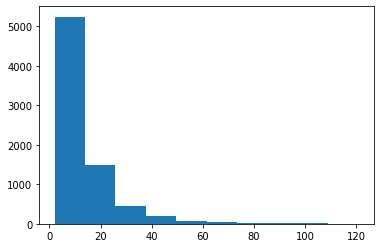


max_stc_length 121



['變得很喘', '我沒有哈哈哈他也沒有', '不然之前我想說奇怪怎麼換藥之後就是自己在懷疑']
tensor([ 138,  112, 6365, 2533, 2523, 1596,  112,  117,  112, 2769, 3760, 3300,
        1506, 1506, 1506,  800,  738, 3760, 3300,  112,  117,  112,  679, 4197,
         722, 1184, 2769, 2682, 6303, 1936, 2597, 2582, 7938, 2994, 5973,  722,
        2527, 2218, 3221, 5632, 2346, 1762, 2755, 4542,  112,  140,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0])
tensor([[24, 24, 24, 24,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  

In [12]:
# ---------------模型---------------
batchsize= 64
model = model_crf(n_tags= n_tags, hidden_dim= 256, batchsize= batchsize).to(device)
# print(summary(model,[(128, 300), (128,300)]))

train_x, test_x, train_y, test_y = train_test_split(stcs, labels, test_size= 0.2, shuffle= True, random_state= 42)

train_dataset = bert_stc_dataset(stcs= train_x, labels= train_y, tokenizer= tokenizer, max_length= max_length)
print(train_x[0:3])
print(train_dataset[0:3]['input_ids'])
print(train_dataset[0:3]['labels'])
test_dataset = bert_stc_dataset(stcs= test_x, labels= test_y, tokenizer= tokenizer, max_length= max_length)

print('training stcs 總數: {}'.format(len(train_dataset)))
train_dataloader = DataLoader(train_dataset, batch_size= batchsize, shuffle= True, num_workers= 0)
test_dataloader = DataLoader(test_dataset, batch_size= batchsize, shuffle= False, num_workers= 0)

num_epochs = 40
num_iteration = len(train_dataloader)
print('num_iteration',num_iteration)
total_iter = num_iteration * num_epochs
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay= 0.0001)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=500, num_training_steps=total_iter)
# warmup_scheduler = warmup.ExponentialWarmup(optimizer, warmup_period=150)

# ---------------訓練---------------
# train_model = train(model= model, optimizer= optimizer, train_loader= train_dataloader, test_loader= 0, num_epochs= 5, device= device)

# test function

In [13]:
def test(model, test_dataloader, device):

  preds_epoch = []
  gts_epoch = []
  epoch_loss = 0
  iteration = 0

  model.eval()

  for idx, batch_dict in enumerate(test_dataloader):

    # print('idx: ',idx+1)
    input_ids = batch_dict['input_ids'].to(device)
    attention_mask = batch_dict['attention_mask'].to(device)
    labels = batch_dict['labels'].to(device)

    with torch.no_grad():
      loss, pred_labels = model(input_ids, attention_mask.bool(), labels)

    # mask gt labels 
    labels = batch_dict['labels'].numpy()
    masks = batch_dict['attention_mask'].numpy()

    labels_nopad = []
    for label , seq_mask in zip(labels, masks):

      seq = [tag for tag, mask in zip(label, seq_mask) if mask == 1]
      labels_nopad.append(seq)

    # one dim array 
    preds= [tag for seq in pred_labels for tag in seq]
    gts= [tag for seq in labels_nopad for tag in seq]

    preds_epoch += preds
    gts_epoch += gts

    epoch_loss += loss.item()
    iteration += 1

  f1_macro = f1_score(y_true= gts_epoch, y_pred= preds_epoch, average= 'macro')
  f1_micro = f1_score(y_true= gts_epoch, y_pred= preds_epoch, average= 'micro')
  f1 = f1_score(y_true= gts_epoch, y_pred= preds_epoch, average= None)
  avg_loss = epoch_loss / iteration
  
  print('test_f1(macro, micro) ({:.2f},{:.2f}) | test_avg_loss {:.2f} | f1 for each class{}'.format(f1_macro, f1_micro, avg_loss, f1))

  return f1_macro, f1_micro, avg_loss

# test out function

In [14]:
class test_output():
	def __init__(self, data, model, tokenizer, batch_size):

		self.model = model
		self.tokenizer = tokenizer
		self.batch_size = batch_size
		self.data_list = []
		self.word_id = []
		self.word_article_id = [] 
		article_id = 0
		word_id = 0
		data_list_tmp = []
		article_id_tmp = []
		word_id_tmp = []
		
		for row in data:
			
			data_tuple = tuple()
			if row == '\n':
				
				article_id += 1 
				word_id = 0
				self.word_id.append(word_id)
				self.word_article_id.append(article_id_tmp)
				self.data_list.append(data_list_tmp)
				data_list_tmp = []
				article_id_tmp = []
				word_id_tmp = []

			else:
				
				row = row.strip('\n').split(' ')

				if row[0] in ['。', '？','！','，','～','：','‧']:
					
					self.word_id.append(word_id_tmp)
					self.word_article_id.append(article_id_tmp)
					self.data_list.append(data_list_tmp)
					data_list_tmp = []
					article_id_tmp = []
					word_id_tmp = []
					
				elif row[0] in ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']:
					  
					data_tuple = (row[0].lower(), article_id, word_id)
					data_list_tmp.append(data_tuple)
					article_id_tmp.append(article_id)
					word_id_tmp.append(word_id)

				elif row[0] not in ['摁','嗯','啦','喔','欸','啊','齁','嘿','…','...','、','，']:
					
					data_tuple = (row[0], article_id, word_id)
					data_list_tmp.append(data_tuple)
					article_id_tmp.append(article_id)
					word_id_tmp.append(word_id)
					
				word_id += 1
				
		if len(data_list_tmp) != 0:
			self.data_list.append(data_list_tmp)
			self.word_id.append(word_id_tmp)
			self.word_article_id.append(article_id_tmp)
			
	def raw_output(self):
		return self.data_list, self.word_id, self.word_article_id

	def get_stcs(self):
		
		all_stcs = list()
		all_article_ids = list()
		all_word_ids = list()

		for stc_list in self.data_list:

			txt_len = len(stc_list) #(文章數，每個文章對應的總字數) (word, label)
			stc = str() #存字數= max_stc_len的字串
			article_ids = []
			word_ids = []
			

			for idx, (word,article_id, word_id) in enumerate(stc_list):

				stc += word
				article_ids.append(article_id)
				word_ids.append(word_id)

			all_stcs.append(stc)
			all_article_ids.append(article_ids)
			all_word_ids.append(word_ids)

		assert len(all_stcs) > 0, 'all stcs len = 0' 

		all_stcs_clean = []
		all_article_ids_clean = []
		all_word_ids_clean = []
		idx = 0
		
		for stc, article_id, word_id in zip(all_stcs, all_article_ids, all_word_ids):
			stc_clean = re.sub(r'(醫師)|(個管師)|(民眾)|(家屬)|(護理師)', '', stc)
			# print(stc, stc_clean, label)
			if len(stc_clean) > 1:  
			# print(stc_clean, stc)
				all_stcs_clean.append(stc)
				all_article_ids_clean.append(article_id)
				all_word_ids_clean.append(word_id)

			# 這一步就先把label 做 0 padding
			
		max_length = len(max(all_stcs_clean, key=len))
		assert max_length > 0, 'max length less than 1'

		print('sentences總數: {}'.format(len(all_stcs_clean)))
			
		# return all_stcs_clean, all_article_ids_clean, all_word_ids_clean

		self.clean_stcs, self.clean_article_id, self.clean_word_id = [], [] ,[]

		for stc, article_id, word_id in zip(stcs, article_ids, word_ids):
		#print(stc, article_id, word_id)
			if stc not in ['沒有','也沒有','哪個','那個','算了','不用','有','有有有','有嗎','一點點', '謝謝','不會','不好意思','對不對','好不好','要嗎','還好']:
				self.clean_stcs.append(stc)
				self.clean_article_id.append(article_id)
				self.clean_word_id.append(word_id)
		return self.clean_stcs, self.clean_article_id, self.clean_word_id

	def encoding(self):
    
		clean_stcs, _, _ = self.get_stcs()
		max_len = max(len(txt) for txt in clean_stcs)

		encoding = self.tokenizer.batch_encode_plus(clean_stcs, 
			padding=True,
			add_special_tokens=False,
			return_attention_mask= True,
			return_token_type_ids= False,
			#  is_split_into_words=True,
			return_tensors='pt')

		# batch_size= 32
		pred_labels = []

		for idx in range(int((len(clean_stcs)/self.batch_size))):
			input= encoding['input_ids'][idx*self.batch_size:(idx+1)*self.batch_size].to(device)
			mask = encoding['attention_mask'][idx*self.batch_size:(idx+1)*self.batch_size].to(device)
			tags= torch.zeros((input.size(0),input.size(1)), dtype=torch.long).to(device)
			_, preds = model(input, mask, tags)
			for pred in preds:
				pred_labels.append(pred)

		idx = int((len(clean_stcs)/self.batch_size))
		input= encoding['input_ids'][idx*self.batch_size:].to(device)
		mask = encoding['attention_mask'][idx*self.batch_size:].to(device)
		tags= torch.zeros((input.size(0),input.size(1)), dtype=torch.long).to(device)
		_, preds = model(input, mask, tags)
		for pred in preds:
			pred_labels.append(pred)

		tag2id = {'[PAD]': 0, 'B-ID': 1, 'B-clinical_event': 2, 'B-contact': 3, 'B-education': 4, 'B-family': 5, 'B-location': 6, 'B-med_exam': 7, 'B-money': 8, 'B-name': 9, 'B-organization': 10, 'B-profession': 11, 'B-time': 12, 'I-ID': 13, 'I-clinical_event': 14, 'I-contact': 15, 'I-education': 16, 'I-family': 17, 'I-location': 18, 'I-med_exam': 19, 'I-money': 20, 'I-name': 21, 'I-organization': 22, 'I-profession': 23, 'I-time': 24, 'O': 25}
		id2tag ={v:k for k, v in tag2id.items()}

		self.pred_labels_tag = []
		for label in pred_labels:
			stc_label = [id2tag[id] for id in label]
			self.pred_labels_tag.append(stc_label)

		return self.pred_labels_tag

	def pred_out_tsv(self):
		
		clean_stcs, clean_article_id, clean_word_id = self.get_stcs()
		pred_labels_tag = self.encoding()

		entity_text = []

		for stc, labels, article_id, word_id in zip(clean_stcs, pred_labels_tag, clean_article_id, clean_word_id):

			entity = str()

			start_pos = 0
			end_pos = 0
			article = 0

			entity_type = str()


			for idx, label in enumerate(labels):
				if bool(re.match(r'B-', label)):
					entity += list(stc)[idx]
					start_pos = word_id[idx]
					article = article_id[idx]
					entity_type = label.split('B-')[1]

				elif bool(re.match(r'I-', label)):
					entity += list(stc)[idx]
					end_pos= word_id[idx]
					try:
						if (labels[idx+1] == 'O') & (entity_type!=''):
							entity_text.append((article, start_pos, end_pos, entity, entity_type))

							entity = str()
							start_pos = 0
							end_pos = 0
							article = 0
							entity_type = str()
					except:
						pass
		with open('test_output.tsv', 'w', encoding='utf-8',newline='\n') as f:
			writer = csv.writer(f, delimiter='\t')
			writer.writerow(['article_id','start_position', 'end_position', 'entity_text', 'entity_type'])
			for (article, start_pos, end_pos, entity, entity_type) in entity_text:
				writer.writerow([str(article), str(start_pos), str(end_pos), str(entity), str(entity_type)])

		return entity_text


# 訓練

In [ ]:
train_loss = {}
test_loss = {}
train_f1 = {}
test_f1 = {}
stop_epoch = 0

for epoch in range(num_epochs):

  preds_epoch = []
  gts_epoch = []
  epoch_loss = 0
  iteration = 0

  model.train()

  for idx, batch_dict in enumerate(train_dataloader):

    # print('idx: ',idx+1)
    input_ids = batch_dict['input_ids'].to(device)
    attention_mask = batch_dict['attention_mask'].to(device)
    labels = batch_dict['labels'].to(device)

    loss, pred_labels = model(input_ids, attention_mask.bool(), labels)

    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

    optimizer.step()
    scheduler.step()
    model.zero_grad()

    # mask gt labels 
    labels = batch_dict['labels'].numpy()
    masks = batch_dict['attention_mask'].numpy()

    labels_nopad = []
    for label , seq_mask in zip(labels, masks):

        seq = [tag for tag, mask in zip(label, seq_mask) if mask == 1]
        labels_nopad.append(seq)

    # one dim array 
    preds= [tag for seq in pred_labels for tag in seq]
    gts= [tag for seq in labels_nopad for tag in seq]

    preds_epoch += preds
    gts_epoch += gts

    epoch_loss += loss.item()
    iteration += 1

  f1_macro = f1_score(y_true= gts_epoch, y_pred= preds_epoch, average= 'macro')
  f1_micro = f1_score(y_true= gts_epoch, y_pred= preds_epoch, average= 'micro')
  f1 = f1_score(y_true= gts_epoch, y_pred= preds_epoch, average= None)
  avg_loss = epoch_loss / iteration
  stop_epoch = epoch+1

  print('epoch {}/{} | train_f1(macro, micro) ({:.2f},{:.2f}) | train_epoch_avg_loss {:.2f}| f1 for each class {}'.format(epoch+1, num_epochs, f1_macro, f1_micro, avg_loss, f1))

  test_f1_macro, test_f1_micro, test_avg_loss = test(model= model, test_dataloader= test_dataloader, device= device)

  train_loss[epoch+1] = avg_loss
  test_loss[epoch+1] = test_avg_loss
  train_f1[epoch+1] = f1_macro
  test_f1[epoch+1] = test_f1_macro


epoch 1/40 | train_f1(macro, micro) (0.03,0.48) | train_epoch_avg_loss 5.75| f1 for each class [0.00000000e+00 0.00000000e+00 1.86915888e-03 0.00000000e+00
 0.00000000e+00 2.25225225e-03 3.32557366e-03 1.52322925e-03
 2.21157390e-03 0.00000000e+00 0.00000000e+00 2.44295921e-02
 5.54323725e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 5.56586271e-03 7.06713781e-03 3.94477318e-03
 2.78940028e-03 0.00000000e+00 2.17450394e-03 8.97435897e-03
 6.59549991e-01]
test_f1(macro, micro) (0.04,0.86) | test_avg_loss 1.22 | f1 for each class[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.02425876
 0.         0.         0.         0.         0.         0.
 0.01169591 0.         0.01515152 0.         0.         0.
 0.92651535]
epoch 2/40 | train_f1(macro, micro) (0.04,0.87) | train_epoch_avg_loss 1.02| f1 for each class [0.         0.         0.         0.         0.         0.
 0.01232033 0.         0.         0. 

# 訓練成果

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows= 2, ncols= 1, figsize= (10,8), sharex= True)
ax1.plot([*range(1, stop_epoch+1)], list(train_loss.values()), label= 'train loss')
ax1.plot([*range(1, stop_epoch+1)], list(test_loss.values()), label= 'test loss')
ax1.legend()

ax2.plot([*range(1, stop_epoch+1)], list(train_f1.values()), label= 'train f1 (macro)')
ax2.plot([*range(1, stop_epoch+1)], list(test_f1.values()), label= 'test f1 (macro)')
ax2.legend()
plt.savefig('fig.jpeg')
plt.tight_layout()
plt.show()

In [ ]:
# torch.save(model, 'ner_model_batch32_wup4000_lstmhd256_lr5e-5_40epoch_adam_wde-3.pt')

In [ ]:
# !cp 'ner_model_batch32_wup4000_lstmhd256_lr5e-5_40epoch_adam_wde-3.pt' '/content/drive/My Drive/python檔/aicup'

In [ ]:
with open('/content/drive/My Drive/python檔/aicup/test_input.data', 'r', encoding= 'utf-8') as f:
    data = f.readlines()

In [ ]:
pred_outs = test_output(data= data, model= model, tokenizer=tokenizer, batch_size= 32).pred_out_tsv()

In [ ]:
pred_outs